In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cftime
import regionmask

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import cartopy.feature as cfeature
import matplotlib.mlab as mlab
import cartopy.io.shapereader as shapereader
from dask.diagnostics import ProgressBar
from scipy import stats
import os
import sys

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = 'Tahoma'
mpl.rcParams['pdf.fonttype'] = 42 

import copy

import geopandas as gp
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import climate_droughts_xr_funcs

### Import files

In [5]:
input_dir = 'D:/for_georgy/FINAL_VERSIONS/'

In [6]:
hist_ens = xr.open_dataset(input_dir + 'hist_merged_regridded_aus_2deg_2s2e.nc')

In [7]:
lm_ens = xr.open_dataset(input_dir + 'lm_merged_regridded_aus_2deg_2s2e.nc')

In [8]:
cntl_ens_aus = xr.open_dataset(input_dir + 'ctrl_merged_regridded_aus_2deg_2s2e.nc')

In [9]:
awap_gf_annual = xr.open_dataset('D:/for_georgy/historical_1900/aus_2degrees/awap_gf_annual_2d.nc')

awap_gf_annual = awap_gf_annual[['pre', 'PRECT_mm', 'drought_years_2s2e', 'droughts_2s2e', 'droughts_2s2e_max',
                             'droughts_2s2e_mean', 'droughts_2s2e_no_of_events', 'droughts_2s2e_std',
                             'droughts_2s2e_intensity', 'droughts_2s2e_severity']]

### Calculate intensity and severity as percentages

In [10]:
def mean_intensity_severity_percentage(ds, threshold_start, threshold_end):
    ds_clim = ds.where((ds['year'] >= threshold_start) & (ds['year'] <= threshold_end), drop=True)
#     ds_clim = ds.where((ds.year >= threshold_start and ds.year < threshold_end), drop=True)
    ds['droughts_2s2e_intensity_pc'] = ds.droughts_2s2e_intensity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_2s2e_intensity_pc_mean'] = ds.droughts_2s2e_intensity_pc.mean(dim='year') * -100
    ds['droughts_2s2e_severity_pc'] = ds.droughts_2s2e_severity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_2s2e_severity_pc_mean'] = ds.droughts_2s2e_severity_pc.mean(dim='year') * -100

In [11]:
mean_intensity_severity_percentage(hist_ens, 1900, 2000)
mean_intensity_severity_percentage(lm_ens, 1900, 2000)
mean_intensity_severity_percentage(cntl_ens_aus, cntl_ens_aus.year[0], cntl_ens_aus.year[-1])

In [12]:
mean_intensity_severity_percentage(awap_gf_annual, 1900, 2000)
awap_gf_annual['droughts_2s2e_intensity_pc_mean'] = awap_gf_annual.droughts_2s2e_intensity_pc.mean(dim='year') * -100
awap_gf_annual['droughts_2s2e_severity_pc_mean'] = awap_gf_annual.droughts_2s2e_severity_pc.mean(dim='year') * -100

In [13]:
# shapefile for plotting
mdb = gp.read_file("D:/shapefiles/MDB_shapefile/Murray.shp")

### Plot mean and maximum drought length

In [14]:
hist_ens["droughts_2s2e_mean"] = xr.where(hist_ens.droughts_2s2e_mean >= 0.000000001, hist_ens.droughts_2s2e_mean, np.NaN)
hist_ens["droughts_2s2e_max"] = xr.where(hist_ens.droughts_2s2e_max >= 0.000000001, hist_ens.droughts_2s2e_max, np.NaN)

lm_ens["droughts_2s2e_mean"] = xr.where(lm_ens.droughts_2s2e_mean >= 0.000000001, lm_ens.droughts_2s2e_mean, np.NaN)
lm_ens["droughts_2s2e_max"] = xr.where(lm_ens.droughts_2s2e_max >= 0.000000001, lm_ens.droughts_2s2e_max, np.NaN)

cntl_ens_aus["droughts_2s2e_mean"] = xr.where(cntl_ens_aus.droughts_2s2e_mean >= 0.000000001, cntl_ens_aus.droughts_2s2e_mean, np.NaN)
cntl_ens_aus["droughts_2s2e_max"] = xr.where(cntl_ens_aus.droughts_2s2e_max >= 0.000000001, cntl_ens_aus.droughts_2s2e_max, np.NaN)

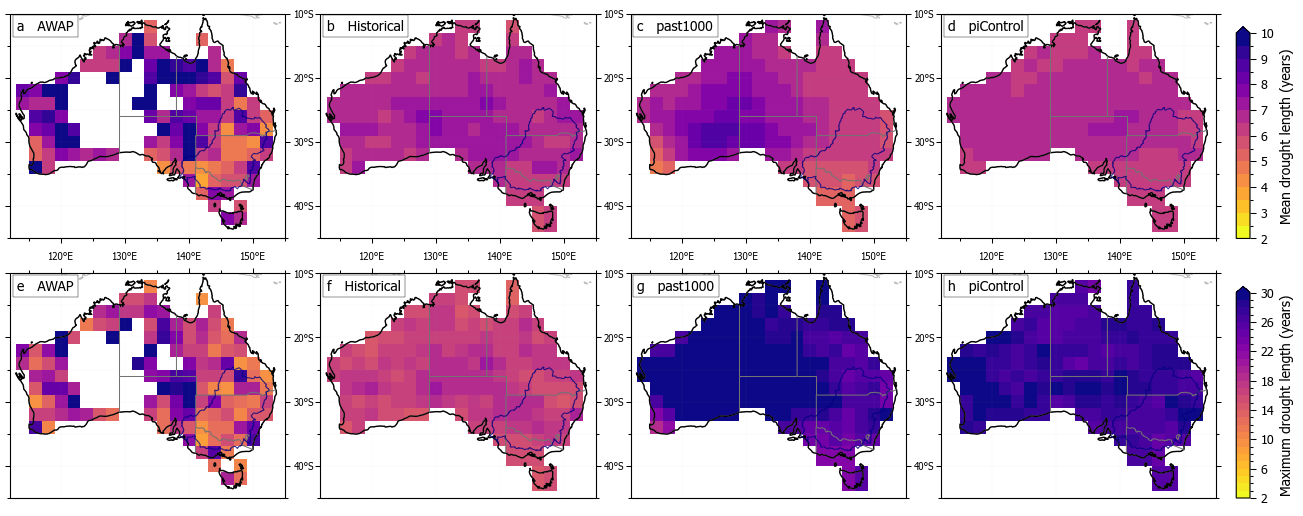

In [15]:
drought_type = 'droughts_2s2e_mean'
drought_type2 = 'droughts_2s2e_max'

lons = [awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon, awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon, awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat, awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat, awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual[drought_type], hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model'),
        awap_gf_annual[drought_type2], hist_ens[drought_type2].mean(dim='model'),
        lm_ens[drought_type2].mean(dim='model'), cntl_ens_aus[drought_type2].mean(dim='model')]


# mean
colorbar_label1 = 'Mean drought length (years)'
contour_levels1 = np.arange(2, 10.5, 0.5)
cmap1 = plt.cm.get_cmap('plasma_r')
cbar_ticks1 = np.arange(2,11,1)
cbar_minor_ticks1 = np.arange(2,10.5, 0.5)

# max cmap
colorbar_label2 = 'Maximum drought length (years)'
contour_levels2 = np.arange(2, 31, 1)
cmap2 = plt.cm.get_cmap('plasma_r')
cbar_ticks2 = np.arange(2,32,4)
cbar_minor_ticks2 = np.arange(2,31,1)

# ---
cmaps = [cmap1, cmap2]

contour_levels = [contour_levels1, contour_levels2]
norms = [BoundaryNorm(contour_levels1, ncolors=cmap1.N, clip=False), 
         BoundaryNorm(contour_levels2, ncolors=cmap2.N, clip=False)]

cbar_ticks = [cbar_ticks1, cbar_ticks2]
cbar_minor_ticks = [cbar_minor_ticks1, cbar_minor_ticks2]
colorbar_label = [colorbar_label1, colorbar_label2]

# ---
label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   Historical', 'c   past1000', 'd   piControl',
                 'e   AWAP', 'f   Historical', 'g   past1000', 'h   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(16,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 4),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='edge',
                cbar_pad=0.2, cbar_size='5%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 4:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i >= 4 and i <= 8:
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', pad=6.5)
    if i <= 4:
        ax.tick_params(axis='x', pad=6.5)
            
    if i % 4 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize )
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 4:
        ax.xaxis.set_ticks_position('top')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='navy', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines
    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps[i//4]
                      , norm=norms[i//4]
                     )
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)


    if i % 4:
        cbar = plt.colorbar(p, cax=axgr.cbar_axes[i//4], extend='max', extendfrac=0.03, ticks=cbar_ticks[i//4])
        cbar.set_label(colorbar_label[i//4], fontsize=10)
        cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=0.75)
        cbar.ax.yaxis.set_ticks(cbar_minor_ticks[i//4], minor=True) 
        cbar.ax.tick_params(width=linewidth_border, which='minor')  

plt.show()

### Plot drought relative intensity and severity

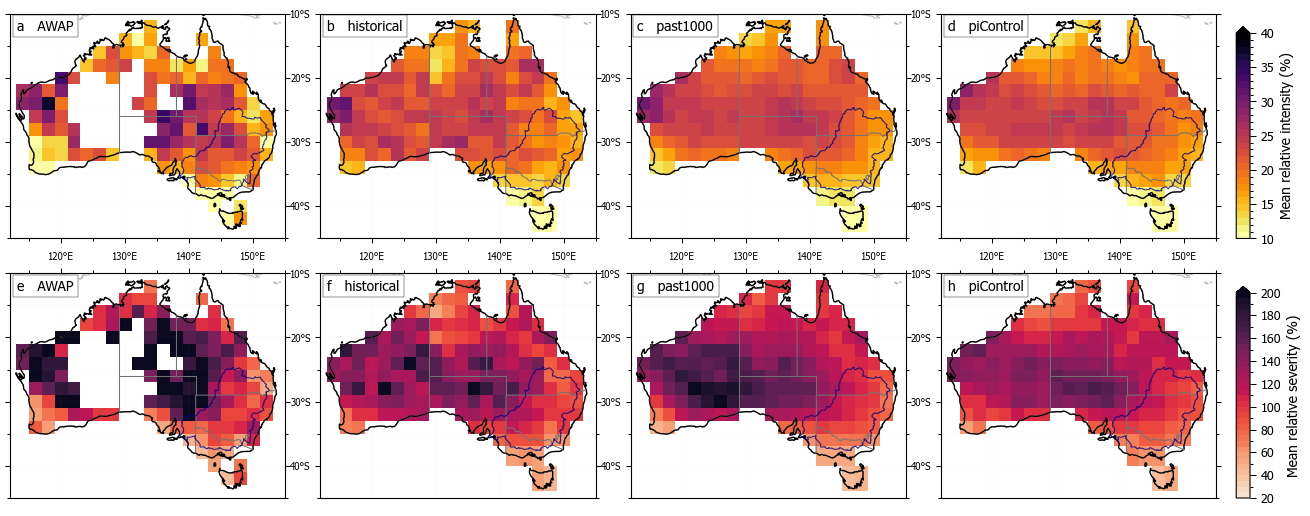

In [16]:
drought_type = 'droughts_2s2e_intensity_pc_mean'
drought_type2 = 'droughts_2s2e_severity_pc_mean'

lons = [awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon, awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat, awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual[drought_type], hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model'),
        awap_gf_annual[drought_type2], hist_ens[drought_type2].mean(dim='model'),
        lm_ens[drought_type2].mean(dim='model'), cntl_ens_aus[drought_type2].mean(dim='model')]


# intensity
contour_levels1 = np.arange(10, 41, 1)
cmap1 = plt.cm.get_cmap('inferno_r')
# cmaps = palette
cbar_ticks1 = np.arange(10,45,5)
cbar_minor_ticks1 = np.arange(10,41,1)

# severity
contour_levels2 = np.arange(20, 205, 5)
cbar_ticks2 = np.arange(20,220,20)
cbar_minor_ticks2 = np.arange(20,210,10)
cmap2 = ListedColormap(sns.color_palette("rocket_r", 40)) # colour_palette() just gives a list of values; 
# ListedColorMap turns it into the color map that the rest of the code wants

# ---
cmaps = [cmap1, cmap2]

contour_levels = [contour_levels1, contour_levels2]
norms = [BoundaryNorm(contour_levels1, ncolors=cmap1.N, clip=False), 
         BoundaryNorm(contour_levels2, ncolors=cmap2.N, clip=False)]

cbar_ticks = [cbar_ticks1, cbar_ticks2]
colorbar_label = ['Mean relative intensity (%)', 'Mean relative severity (%)']
cbar_minor_ticks = [cbar_minor_ticks1, cbar_minor_ticks2]

# ---
label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   historical', 'c   past1000', 'd   piControl',
                 'e   AWAP', 'f   historical', 'g   past1000', 'h   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(16,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 4),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='edge',
                cbar_pad=0.2, cbar_size='5%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i == 0 or i == 4:
        for label in ax.get_yticklabels():
            label.set_visible(False)
#         ax.yaxis.set_ticks_position('right')

    if i >= 4:
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', pad=6.5)
       
    if i <= 4:
        ax.tick_params(axis='x', pad=6.5)

    if i >= 4:
        ax.xaxis.set_ticks_position('top')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='navy', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines
    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps[i//4], norm=norms[i//4]
                     )

    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)


    if i % 4:
        cbar = plt.colorbar(p, cax=axgr.cbar_axes[i//4], extend='max', extendfrac=0.03, ticks=cbar_ticks[i//4])
        cbar.set_label(colorbar_label[i//4], fontsize=10)
        cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=0.75)
        cbar.ax.yaxis.set_ticks(cbar_minor_ticks[i//4], minor=True) 
        cbar.ax.tick_params(width=linewidth_border, which='minor')  

plt.show()

### Plot number of droughts per 100 years and proportion of time spent in drought

In [18]:
awap_gf_annual_droughts_2s2e_no_events_100yrs = xr.where(awap_gf_annual.droughts_2s2e_no_of_events >= 0.000000001, awap_gf_annual.droughts_2s2e_no_of_events, np.NaN)

hist_ens["droughts_2s2e_no_events_100yrs"] = xr.where(hist_ens.droughts_2s2e_no_of_events >= 0.000000001, hist_ens.droughts_2s2e_no_of_events, np.NaN)

lm_ens["droughts_2s2e_no_events_100yrs"] = lm_ens.droughts_2s2e_no_of_events/11.39
lm_ens["droughts_2s2e_no_events_100yrs"] = xr.where(lm_ens.droughts_2s2e_no_events_100yrs >= 0.000000001, lm_ens.droughts_2s2e_no_events_100yrs, np.NaN)

cntl_ens_aus["droughts_2s2e_no_events_100yrs"] = cntl_ens_aus.droughts_2s2e_no_of_events/5
cntl_ens_aus["droughts_2s2e_no_events_100yrs"] = xr.where(cntl_ens_aus.droughts_2s2e_no_events_100yrs >= 0.000000001, cntl_ens_aus.droughts_2s2e_no_events_100yrs, np.NaN)

In [19]:
awap_gf_annual['droughts_2s2e_sum_100yrs'] = awap_gf_annual.drought_years_2s2e.sum(dim = 'year')
awap_gf_annual['droughts_2s2e_sum_100yrs'] = xr.where(awap_gf_annual.droughts_2s2e_sum_100yrs >= 0.000000001, awap_gf_annual.droughts_2s2e_sum_100yrs, np.NaN)

hist_ens['droughts_2s2e_sum_100yrs'] = xr.where(hist_ens.droughts_2s2e_sum_100yrs >= 0.000000001, hist_ens.droughts_2s2e_sum_100yrs, np.NaN)

lm_ens['droughts_2s2e_sum_100yrs'] = xr.where(lm_ens.droughts_2s2e_sum_100yrs >= 0.000000001, lm_ens.droughts_2s2e_sum_100yrs, np.NaN)

cntl_ens_aus['droughts_2s2e_sum_100yrs'] = xr.where(cntl_ens_aus.droughts_2s2e_sum_100yrs >= 0.000000001, cntl_ens_aus.droughts_2s2e_sum_100yrs, np.NaN)

awap_gf_annual_droughts_2s2e_sum_100yrs = awap_gf_annual['droughts_2s2e_sum_100yrs']

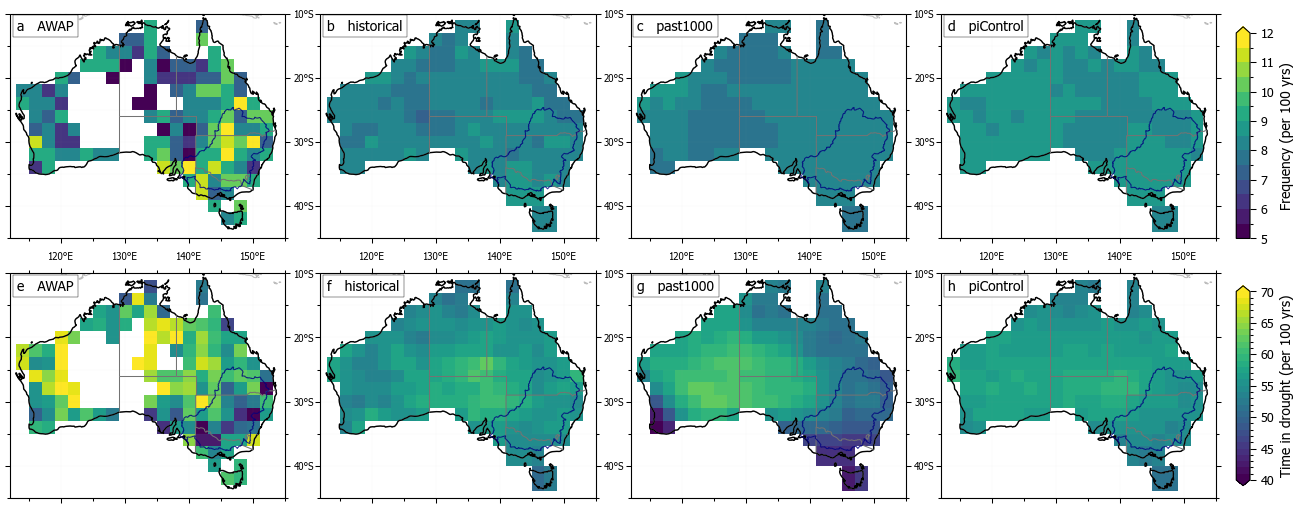

In [20]:
drought_type = 'droughts_2s2e_no_events_100yrs'
drought_type2 = 'droughts_2s2e_sum_100yrs'

lons = [awap_gf_annual_droughts_2s2e_no_events_100yrs.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon, awap_gf_annual_droughts_2s2e_sum_100yrs.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual_droughts_2s2e_no_events_100yrs.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat, awap_gf_annual_droughts_2s2e_sum_100yrs.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual_droughts_2s2e_no_events_100yrs, hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model'),
        awap_gf_annual_droughts_2s2e_sum_100yrs, hist_ens[drought_type2].mean(dim='model'),
        lm_ens[drought_type2].mean(dim='model'), cntl_ens_aus[drought_type2].mean(dim='model')]


# intensity
contour_levels1 = np.arange(5, 12.5, 0.5)
cmap1 = plt.cm.get_cmap('viridis')
# cmaps = palette
cbar_ticks1 = np.arange(5,13,1)
cbar_minor_tick1 = np.arange(5,12.5,.5)

contour_levels2 = np.arange(40, 71,1)
cbar_ticks2 = np.arange(40,75,5)
cmap2 = plt.cm.get_cmap('viridis')
cbar_minor_tick2 = np.arange(40,71,1)
# ---
cmaps = [cmap1, cmap2]

contour_levels = [contour_levels1, contour_levels2]
norms = [BoundaryNorm(contour_levels1, ncolors=cmap1.N, clip=False), 
         BoundaryNorm(contour_levels2, ncolors=cmap2.N, clip=False)]

cbar_ticks = [cbar_ticks1, cbar_ticks2]
colorbar_label = ['Frequency (per 100 yrs)', 'Time in drought (per 100 yrs)']

cbar_extend = ['max', 'both']
cbar_minor_ticks = [cbar_minor_tick1, cbar_minor_tick2]

# ---
label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   historical', 'c   past1000', 'd   piControl',
                 'e   AWAP', 'f   historical', 'g   past1000', 'h   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(16,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 4),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='edge',
                cbar_pad=0.2, cbar_size='5%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 4:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i >= 4:
        ax.xaxis.set_ticks_position('top')
        ax.tick_params(axis='x', pad=6.5)
    
    if i <= 4:
        ax.tick_params(axis='x', pad=6.5)
        
            
    if i % 4 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize )
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 4:
        ax.xaxis.set_ticks_position('both')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='navy', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines
    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps[i//4], norm=norms[i//4]
                     )

    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)


    if i % 4:
        cbar = plt.colorbar(p, cax=axgr.cbar_axes[i//4], extend=cbar_extend[i//4], extendfrac=0.03, ticks=cbar_ticks[i//4])
        cbar.set_label(colorbar_label[i//4], fontsize=10)
        cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=0.75)
        
        cbar.ax.yaxis.set_ticks(cbar_minor_ticks[i//4], minor=True) 
        cbar.ax.tick_params(width=linewidth_border, which='minor')

plt.show()